<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# [Tutoriel d'apprentissage automatique](https://github.com/wikistat/MLTraining)

# *NLP* et Catégorisation de Produits en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="R"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="scikit-learn"/></a> et <a href="https://radimrehurek.com/gensim/index.html" ><img src="https://radimrehurek.com/gensim/_static/images/gensim.png" style="max-width: 100px; display: inline" alt="gensim"/></a> 

#### Résumé
Le principal objectif est d'illuster sur des vraies données les processus d'analyse de données textuelles ou de langage naturel (NLP). Plusieurs étapes sont considérées et exécutées dans l'environnement Pyhton avec le slibrairies spécialisées. Nesttoyage des textes, éliminaiton des mots inutiles, racinisation ainsi que la comparaison de différentes stratgies de vectorisation (comptage, TF-IDF, word2vect). A la suite de quoi l'onjectif de classificaiton en catégorie est atteint en comparant deux méthodes: régresison logistique et forêts aléatoires.


## 1 Introduction

Il s'agit d'une version simplifiée du concours proposé par CDiscount et paru sur le site [datascience.net](https://www.datascience.net/fr/challenge) puis Kaggle. Les données d'apprentissage sont accessibles sur demande auprès de CDiscount. Les solutions de l'échantillon test du concours ne sont pas et ne seront pas rendues publiques. Un échantillon test est donc construit pour l'usage de ce tutoriel.  L'objectif est de prévoir la catégorie d'un produit à partir de son descriptif. Seule la catégorie principale (1er niveau) est prédite au lieu des trois niveaux demandés dans le concours. L'objectif est d'illustrer sur un exemple complexe le prétraitement de données textuelles ou de langave naturel (*Natural Language Process - NLP*). La stratégie de sous ou sur échantillonnage des catégories qui permet d'améliorer la prévision n'a pas été mise en oeuvre.
* L'exemple est présenté sur un échantillon réduit d'un million de produits au lieu des 15M initiaux
* L'échantillon réduit peut encore l'être puis séparé en 2 parties: apprentissage et validation. 
* Les données textuelles sont  nettoyées, racinisées, vectorisées avant modélisation.
* Deux modélisations sont estimées: logistique, forêts aléatoires.

## 2 Prise en charge des données
### 2.1 Environnement

In [1]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import collections
import itertools
import warnings

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

import sklearn.model_selection as scv

**Attetnion** Si vous utilisez la librairie `nltk` pour la première fois dans votre environnement, il est nécessaire d'exécuter la commande suivante. Cette commande permet de télécharger de nombreux corpus de texte, mais également des informations grammaticales sur différentes langues; information notamment nécessaire à l'étape de racinisation.

In [2]:
# nltk.download()

### 2.2 Lecture des données

* `cdiscount_train`: 1.000.000 de lignes
* `cdisount_test`: 50.000 lignes

Définition d'une fonction permettant de lire le fichier d'apprentissage et de créer aléatoirement deux *data frames  `Pandas`, un pour l'apprentissage, l'autre pour le test. 

In [3]:
def split_dataset(input_path, nb_line, tauxTest):
    data_all = pd.read_csv(input_path,sep=",", nrows=nb_line)
    data_all = data_all.fillna("")
    data_train, data_test = scv.train_test_split(data_all, test_size = tauxTest)
    time_end = time.time()
    return data_train, data_test

La taille du fichier est limité à `nb_line=10 000` pour réduire les temps de calcul à venir. Ce nombre peut être augmenté afin de tester une amélioraiton des performances mais au prix du temps de calcul. Cette analyse systématique de l'impact de la taille de l'échantillon est développé par [Besse et al. (2017)](https://hal.archives-ouvertes.fr/hal-01350099v3) qui opèrent de plus une comparaison des performances entre R, Python et Spark. 

In [4]:
input_path = "data/cdiscount_train.csv.zip"
nb_line=100000  # part totale extraite du fichier initial ici déjà réduit
tauxTest = 0.05 # proportion de l'échantillon test
data_train, data_test = split_dataset(input_path, nb_line, tauxTest)
# Cette ligne permet de visualiser les 5 premières lignes du DataFrame 
N_train = data_train.shape[0]
N_test = data_test.shape[0]
print("Train set : %d elements, Test set : %d elements" %(N_train, N_test))
data_train.head(5)

Train set : 95000 elements, Test set : 5000 elements


,Categorie1,Categorie2,Categorie3,Description,Libelle,Marque
93386,SPORT (NEW),PECHE,CANNE A PECHE,CANNE PENN SQUADRON 215 TRAVEL BOAT Modèle: 20...,CANNE PENN SQUADRON 215 TRAVEL BOAT Modèle: 20lbs,PENN
94799,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,CABLE - CONNECTIQUE TELEPHONE,"Cable de data compatible HTC, WIKO, NOKIA, SON...",Cable micro USB data pour LG Vu 3 F300L,AUCUNE
97039,BRICOLAGE - OUTILLAGE - QUINCAILLERIE,ELECTRICITE  DOMOTIQUE,BATTERIE,"Specifications:Tension:14,4VCapacite:3000mAh/4...",Batterie pour Bosch type BAT041 NiMH O-Pack 1...,POWERY
58247,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque Samsung Galaxy Core i8260-i8262 – Billar...,Coque Samsung Galaxy Core i8260-i8262 – Billard…,SUTEO
39289,PHOTO - OPTIQUE,ACCESSOIRES PHOTO - OPTIQUE,BATTERIE PHOTO - OPTIQUE,"Specifications:Tension:7,4VCapacite:10400mAh/7...","Batterie pour Sony vidéo DCR-VX2100 7,4V 10400...",POWERY


### 2.3 Exploration élémentaire

In [5]:
# Liste des catégories du premier niveau
data_train.groupby("Categorie1").first()[["Description","Marque"]]

,Description,Marque
Categorie1,,
ADULTE - EROTIQUE,"SECRET PLAY - Mini Plumeau avec Franges ""PROVO...",SECRET PLAY
ANIMALERIE - NEW,Collier en cuir d'agneau evasion pour chien ma...,BOBBY
ARME DE COMBAT - ARME DE SPORT,M3000 Shotgun sawed off pump action full metal...,AUCUNE
ART DE LA TABLE - ARTICLES CULINAIRES,Tasse Akita-Inu-Fauve M-Jaune-Orange - TASSE d...,AUCUNE
ARTICLES POUR FUMEUR,Citron (10ml) - E liquide eFlavor conçu et fab...,AUCUNE
AUTO - MOTO (NEW),Rétroviseur origine Bihr droit Piaggio SKIPPER...,BIHR
BAGAGERIE,Coach Light kaki et rouge Signature Stripe Con...,COACH
BATEAU MOTEUR - VOILIER,"Aérateurs circulaires - Moustiquaire: non, Ø m...",AUCUNE
BIJOUX - LUNETTES - MONTRES,Montre Homme Accutron Amerigo 63B023 - Montre ...,AUCUNE


Dénombrement des catégories du premier niveau.

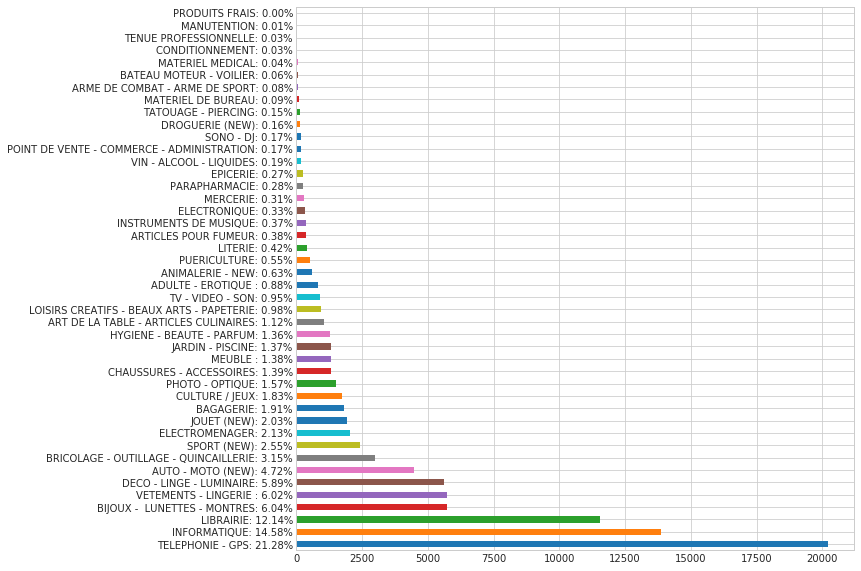

In [6]:
#Count occurence of each Categorie
data_count = data_train["Categorie1"].value_counts()
#Rename index to add percentage
new_index = [k+ ": %.2f%%" %(v*100/N_train) for k,v in data_count.iteritems()]
data_count.index= new_index

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
data_count.plot.barh(logx = False)
plt.show()

Que peut-on dire sur la distribution des ce classes?

Les données sont enregistrées dans les fichiers `train` et `test` de type `csv` pour des réutilisations ultérieures.

In [7]:
data_test.to_csv("data/cdiscount_test.csv", index=False)
data_train.to_csv("data/cdiscount_train_subset.csv", index=False)

##  3. Nettoyage des données
Afin de limiter la dimension de l'espace des variables ou *features*, tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:
* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### 3.1 Importation des librairies et fichier pour le nettoyage des données.

In [8]:
# Librairies 
from bs4 import BeautifulSoup #Nettoyage d'HTML
import re # Regex
import nltk # bibliothèque de fonctions NLP

## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords =open("data/lucene_stopwords.txt","r").read().split(",") #En local
## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

## Fonction de stemming ou de racinisation
stemmer=nltk.stem.SnowballStemmer('french')

### 3.2 Illustration sur un descriptif 

**Ligne Originale**

In [9]:
i = 0
description = data_train.Description.values[i]
print("Original Description : " + description)

Original Description : CANNE PENN SQUADRON 215 TRAVEL BOAT Modèle: 20lbs - CANNE PENN SQUADRON 215 TRAVEL BOAT Modèle: 20lbs… Voir la présentation


** Supprimer les posibles balises HTML dans la description **

In [10]:
# txt = BeautifulSoup(description,"html.parser",from_encoding='utf-8').get_text()
txt = BeautifulSoup(description,"html.parser").get_text()
print(txt)

CANNE PENN SQUADRON 215 TRAVEL BOAT Modèle: 20lbs - CANNE PENN SQUADRON 215 TRAVEL BOAT Modèle: 20lbs… Voir la présentation


** Convertir le texte en minuscule **

In [11]:
txt = txt.lower()
print(txt)

canne penn squadron 215 travel boat modèle: 20lbs - canne penn squadron 215 travel boat modèle: 20lbs… voir la présentation


** Remplacer quelques caractères spéciaux **

* `\u2026`: `…`
* `\u00a0`: `NO-BREAK SPACE`

Cette liste peut être compléter en fonction du jeu de donées étudiés

In [12]:
txt = txt.replace(u'\u2026','.')    
txt = txt.replace(u'\u00a0',' ')
print(txt)

canne penn squadron 215 travel boat modèle: 20lbs - canne penn squadron 215 travel boat modèle: 20lbs. voir la présentation


** Supprimer les accents **

In [13]:
txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
print(txt)

canne penn squadron 215 travel boat modele: 20lbs - canne penn squadron 215 travel boat modele: 20lbs. voir la presentation


** Supprimer les caractères qui ne sont ne sont pas des lettres minuscules **

In [14]:
txt = re.sub('[^a-z_]', ' ', txt)
print(txt)

canne penn squadron     travel boat modele    lbs   canne penn squadron     travel boat modele    lbs  voir la presentation


** Remplacer la description par une liste de mots (tokens), supprimer les mots de moins de 2 lettres ainsi que les stopwords **


In [15]:
tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
print(tokens)

['canne', 'penn', 'squadron', 'travel', 'boat', 'modele', 'lbs', 'canne', 'penn', 'squadron', 'travel', 'boat', 'modele', 'lbs', 'voir', 'presentation']


** Raciniser (stem) chaque tokens **

In [16]:
tokens_stem = [stemmer.stem(token) for token in tokens]
print(tokens_stem)

['cann', 'pen', 'squadron', 'travel', 'boat', 'model', 'lb', 'cann', 'pen', 'squadron', 'travel', 'boat', 'model', 'lb', 'voir', 'present']


### 3.3 Fonctions de nettoyage de texte
Cette fonction qui prend en entrée un texte et retourne le texte nettoyé en appliquant successivement les étapes précédentes. 

In [17]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text()
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens_stem = [stemmer.stem(token) for token in tokens]
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens), " ".join(tokens_stem)

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

In [18]:
from multiprocessing import Pool
p = Pool(4)
    
# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Description', 'Libelle', 'Marque']):
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    clean_stem_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Marque":
            array_clean = np.array(list(p.map(clean_marque,column)))
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean)
        else:
            A = np.array(list(p.map(clean_txt,column)))
            array_clean = A[:,0]
            array_clean_stem = A[:,1]
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean_stem)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    
    array_clean_stem = np.array(clean_stem_list).T
    data_clean_stem = pd.DataFrame(array_clean_stem, columns = column_names)
    return data_clean, data_clean_stem

/home-local/pbesse/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")
/home-local/pbesse/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")
/home-local/pbesse/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")
/home-local/pbes

### 3.4 Nettoyage des *data frames*
Applique le nettoyage sur toutes les lignes du *data frame* et créé deux nouveaux *data frames*: avec et sans l'étape de racinisation)

In [19]:
# Take approximately 2 minutes fors 100.000 rows
data_test_clean, data_test_clean_stem = clean_df(data_test)

Start Clean 5000 lines
Cleaning time: 1 secondes


In [20]:
data_train_clean, data_train_clean_stem = clean_df(data_train)

Start Clean 95000 lines
Cleaning time: 27 secondes


Affiche les 5 premières lignes du DataFrame d'apprentissage après nettoyage.

In [21]:
data_train_clean.head(5)

,Description,Libelle,Marque
0,canne penn squadron travel boat modele lbs can...,canne penn squadron travel boat modele lbs,penn
1,cable data compatible htc wiko nokia sony sams...,cable micro usb data,aucune
2,specifications tension vcapacite mah whtype ba...,batterie bosch type bat nimh pack,powery
3,coque samsung galaxy core billard ref coque su...,coque samsung galaxy core billard,suteo
4,specifications tension vcapacite mah whtype ba...,batterie sony video dcr,powery


In [22]:
data_train_clean_stem.head(5)

,Description,Libelle,Marque
0,cann pen squadron travel boat model lb cann pe...,cann pen squadron travel boat model lb,penn
1,cabl dat compatibl htc wiko noki sony samsung ...,cabl micro usb dat,aucune
2,specif tension vcapacit mah whtyp batter nimhc...,batter bosch typ bat nimh pack,powery
3,coqu samsung galaxy cor billard ref coqu suteo...,coqu samsung galaxy cor billard,suteo
4,specif tension vcapacit mah whtyp batter ionco...,batter sony video dcr,powery


Taille du dictionnaire de mots pour le dataset avant et après la racinisation.

In [23]:
concatenate_text = " ".join(data_train_clean["Description"].values)
list_of_word = concatenate_text.split(" ")
N = len(set(list_of_word))
print(N)

72899


In [24]:
concatenate_text = " ".join(data_train_clean_stem["Description"].values)
list_of_word_stem = concatenate_text.split(" ")
N = len(set(list_of_word_stem))
print(N)

56687


### 3.4 Représentations par *wordcloud*

In [25]:
from wordcloud import WordCloud

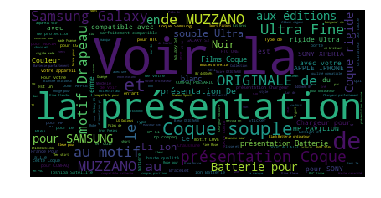

In [26]:
all_descr = " ".join(data_test.Description.values)
wordcloud_word = WordCloud(background_color="black").generate_from_text(all_descr)

plt.figure()
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

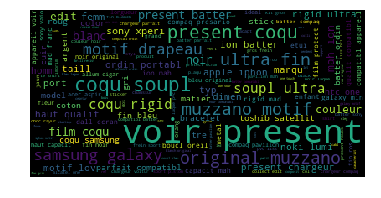

In [27]:
all_descr_clean_stem = " ".join(data_test_clean_stem.Description.values)
wordcloud_word = WordCloud(background_color="black").generate_from_text(all_descr_clean_stem)

plt.figure()
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

Sauvegarder les jeux de données nettoyés avec et sans racinisation dans des fichiers csv. Cela permet de reprendre l'analyse à la suite d'une interuption.

In [28]:
data_test_clean.to_csv("data/cdiscount_test_clean.csv", index=False)
data_train_clean.to_csv("data/cdiscount_train_clean.csv", index=False)

data_test_clean_stem.to_csv("data/cdiscount_test_clean_stem.csv", index=False)
data_train_clean_stem.to_csv("data/cdiscount_train_clean_stem.csv", index=False)

## 4 Construction des caractéristiques ou *features* par vectorisation

Les données textuelles ne peuvent pas être utilisées directment dans les différents algorithmes de d'apprentissage statistique.Plusieurs technique dites de vectorisation permettent de les traduire sous formes de vecteur numérique. Elles sont disponibles dans `Scikit-learn`:
* `One-Hot-Encoder`
* `Hashing`
* `Tf-Idf`

### 4.1 Lecture des données netoyées des étapes précédentes

In [31]:
data_test_clean_stem = pd.read_csv("data/cdiscount_test_clean_stem.csv").fillna("")
data_train_clean_stem = pd.read_csv("data/cdiscount_train_clean_stem.csv").fillna("")

Le dossier `features` créé ci-dessous contiendra les *data frames* des différentes possibilités de vectorisation.

In [32]:
import os
DATA_OUTPUT_DIR = "data/features"
if not(os.path.isdir("data/features")):
    os.mkdir("data/features")

Seule la colonne *Description* des `data frames` est considérée. 

In [33]:
train_array = data_train_clean_stem["Description"].values
test_array = data_test_clean_stem["Description"].values

### 4.2 Vectorisation par  *One-Hot-Encoding*
Les mots sont codés par des présences / absences. Il est également possible de prendre en compte des n-grammes. Les matrices ainsi crées sont stockés dans un format creux ou parcimonieux (*sparse*).

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

extr_cv = CountVectorizer(binary=False)
data_train_OHE = extr_cv.fit_transform(train_array)
data_train_OHE

<95000x56686 sparse matrix of type '<class 'numpy.int64'>'
	with 1118623 stored elements in Compressed Sparse Row format>

In [35]:
vocabulary = extr_cv.get_feature_names()
N_vocabulary = len(vocabulary)
N_vocabulary

56686

Affiche la première ligne

In [36]:
ir = 0

rw = data_train_OHE.getrow(ir)
print(train_array[ir])
pd.DataFrame([(v, vocabulary[v], k)  for k,v in zip(rw.data,rw.indices)], columns=["indices","token","weight"])


cann pen squadron travel boat model lb cann pen squadron travel boat model lb voir present


,indices,token,weight
0,41198,present,1
1,54498,voir,1
2,29670,lb,2
3,34234,model,2
4,6283,boat,2
5,51990,travel,2
6,48448,squadron,2
7,38965,pen,2
8,8229,cann,2


In [37]:
data_test_OHE = extr_cv.transform(test_array)
data_test_OHE

<5000x56686 sparse matrix of type '<class 'numpy.int64'>'
	with 57503 stored elements in Compressed Sparse Row format>

In [38]:
ir = 5

rw = data_test_OHE.getrow(ir)
print(test_array[ir])
pd.DataFrame([(v, vocabulary[v], k)  for k,v in zip(rw.data,rw.indices)], columns=["indices","token","weight"])


mar maman laurenc jyl mar maman laurenc jyl edit franc loisir rel voir present


,indices,token,weight
0,16930,edit,1
1,21039,franc,1
2,29594,laurenc,2
3,30803,loisir,1
4,31800,maman,2
5,31988,mar,2
6,41198,present,1
7,43336,rel,1
8,54498,voir,1


### 4.3 Vectorisation par TF-IDF¶

Le *TF-IDF* permet de faire ressortir l'importance relative de chaque mot $m$, ou couples de mots consécutifs (bi-gram*) dans un texte-produit ou un descriptif $d$, par rapport à la liste entière des produits ou descriptifs. La fonction $TF(m,d)$ compte le nombre d'occurences du mot $m$ dans le descriptif $d$. La fonction $IDF(m)$ mesure l'importance du terme dans l'ensemble des documents ou descriptifs en donnant plus de poids aux termes les moins fréquents car considérés comme les plus discriminants (motivation analogue à celle de la métrique du chi2 en analyse des correspondance). $IDF(m,l)=\log\frac{D}{f(m)}$ où $D$ est le nombre de documents, la taille de l'échantillon d'apprentissage, et $f(m)$ le nombre de documents ou descriptifs contenant le mot $m$. La nouvelle variable ou *features* est $V_m(l)=TF(m,l)\times IDF(m,l)$.

Comme pour les transformations des variables quantitatives (centrage, réduction), la même transformation c'est-à-dire les mêmes pondérations, est calculée sur l'achantillon d'apprentissage et appliquée à celui de test. La fonction `TfidfVectorizer` opèrecette transformation en produisant une matrice creuse. Fixer le paramètre `norm = False` rend les résultats plus explicite.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer( ngram_range=(1,1), norm = False)
data_train_TFIDF = vec.fit_transform(train_array)
data_train_TFIDF

<95000x56686 sparse matrix of type '<class 'numpy.float64'>'
	with 1118623 stored elements in Compressed Sparse Row format>

In [40]:
vocabulary = vec.get_feature_names()
N_vocabulary = len(vocabulary)
N_vocabulary

56686

In [41]:
ir = 0

rw = data_train_TFIDF.getrow(ir)
print(train_array[ir])
pd.DataFrame([(v, vocabulary[v], vec.idf_[v], k)  for k,v in zip(rw.data,rw.indices)], columns=["indices","token","idf","weight"])


cann pen squadron travel boat model lb cann pen squadron travel boat model lb voir present


,indices,token,idf,weight
0,8229,cann,8.018991,16.037983
1,38965,pen,8.569822,17.139645
2,48448,squadron,11.768496,23.536991
3,51990,travel,8.824057,17.648113
4,6283,boat,9.822585,19.645171
5,34234,model,4.504115,9.008231
6,29670,lb,10.852205,21.704410
7,54498,voir,1.335204,1.335204
8,41198,present,1.341626,1.341626


La fonction `TfidfVectorizer` admet plusieurs variantes: *smooth idf, sublinear_tf* ainsi que la possibilité de prendre en compte des n-gram mais la taille du dictionnaire explose.

La même transformation de vectorisation est ensuite appliquée sur le jeu de données test.

In [42]:
data_test_TFIDF = vec.transform(test_array)
data_test_TFIDF

<5000x56686 sparse matrix of type '<class 'numpy.float64'>'
	with 57503 stored elements in Compressed Sparse Row format>

Le *tf* est évalué pour chaque ligne ou descriptif mais pondéré par le même *idf*.

In [43]:
ir = 5

rw = data_test_TFIDF.getrow(ir)
print(test_array[ir])
pd.DataFrame([(v, vocabulary[v], vec.idf_[v], k)  for k,v in zip(rw.data,rw.indices)], columns=["indices","token","idf","weight"])


mar maman laurenc jyl mar maman laurenc jyl edit franc loisir rel voir present


,indices,token,idf,weight
0,54498,voir,1.335204,1.335204
1,43336,rel,8.271988,8.271988
2,41198,present,1.341626,1.341626
3,31988,mar,7.058965,14.117931
4,31800,maman,9.370600,18.741200
5,30803,loisir,8.117837,8.117837
6,29594,laurenc,10.063747,20.127495
7,21039,franc,4.861741,4.861741
8,16930,edit,3.664094,3.664094


### 4.4 Fonction de Hashage

Le *hashnig* permet de réduire l'espace des variables (taille du dictionnaire) en un nombre limité et fixé a priori `n_hash` de caractéristiques ou *features*. Il repose sur la définition d'une fonction de hashage $h$ qui à un indice $j$ défini dans l'espace des entiers naturels, renvoie de façon déterministe et injective un indice $i=h(j)$ dans dans l'espace réduit (1 à n_hash) des caractéristiques. Ainsi le poids de l'indice $i$, du nouvel espace, est l'association de tous les poids d'indice $j$ tels que $i=h(j)$ de l'espace originale. Ici, les poids sont associés d'après la méthode décrite par Weinberger et al. (2009).

N.B. $h$ n'est pas généré aléatoirement. Ainsi pour un même fichier d'apprentissage (ou de test) et pour un même entier `n_hash`, le résultat de la fonction de hashage est identique

Le dictionnaire est pris en paramètre d'entrée.

In [44]:
from sklearn.feature_extraction import FeatureHasher
nb_hash = 300

feathash = FeatureHasher(nb_hash)
train_dict_array  = map(lambda x : collections.Counter(x.split(" ")), train_array)
data_train_hash = feathash.fit_transform(train_dict_array)

In [45]:
data_train_hash

<95000x300 sparse matrix of type '<class 'numpy.float64'>'
	with 1092837 stored elements in Compressed Sparse Row format>

In [46]:
ir = 0

rw = data_train_hash.getrow(ir)
print(train_array[ir])
pd.DataFrame([(v, k)  for k,v in zip(rw.data,rw.indices)], columns=["indices","weight"])


cann pen squadron travel boat model lb cann pen squadron travel boat model lb voir present


,indices,weight
0,42,-2.0
1,68,-2.0
2,94,2.0
3,116,2.0
4,117,-2.0
5,142,2.0
6,149,2.0
7,220,-1.0
8,274,1.0


Cette fonction réduit la taille de la matrice, mais il n'existe pas de fonction inverse explicite à cette transformation. Le résultat perd en lisibilit ou interprétabilité. C'est néanmoins indispensbale si le dictionnaire est très volumineux. Pour la partie d'apprentissage, il est possible d'utiliser la matrice de hashage obtenue comme des présence absence ou encore de lui associer les pondérations issues d'une transformation TF-IDF comme ci-dessous.

In [47]:
from sklearn.feature_extraction.text import TfidfTransformer

vec =  TfidfTransformer(norm = False)
data_train_HTfidf = vec.fit_transform(data_train_hash)
data_train_HTfidf

<95000x300 sparse matrix of type '<class 'numpy.float64'>'
	with 1084478 stored elements in Compressed Sparse Row format>

In [48]:
ir = 0

rw = data_train_HTfidf.getrow(ir)
print(train_array[ir])
pd.DataFrame([(v, vec.idf_[v], k)  for k,v in zip(rw.data, rw.indices)], columns=["indices","idf_","weight"])


cann pen squadron travel boat model lb cann pen squadron travel boat model lb voir present


,indices,idf_,weight
0,274,1.311180,1.311180
1,220,1.326937,-1.326937
2,149,4.798235,9.596470
3,142,4.341946,8.683893
4,117,4.458949,-8.917897
5,116,3.765467,7.530934
6,94,5.321982,10.643965
7,68,5.289986,-10.579972
8,42,4.855753,-9.711505


### 4.5 Fonctions de Vectorisation

Ces transformaitons asdmettent de nombreuses options dont il faut fixer les valeurs des paramètres. Dans les présents tests, seuls 4 jeux d'apprentissage et test sont construits:
* `count` avec des occurences (*one hot*) de 0,1 
   - sans hashage 
   - avec `n_hash=300`
* `TFIDF` 
   - sans hashage 
   - avec `n_hash=300`

D'autres options pourraient être considérées en introduisant des n-grams ou en faisant varier `n_hash` ou encore les variantes de *TFIDF*. 

Les deux fonctions `vectorizer_train` and `apply_vectorizer` permettent de générer les différentes options sur l'échantillon d'apprentissage puis de les appliquéer également à l'échantillon test.

In [49]:
def vectorizer_train(df, columns=['Description'], nb_hash=None, nb_gram = 1, vectorizer = "tfidf" , binary = False):
    
    data_array = [" ".join(line) for line in df[columns].values]
    
    # Hashage
    if nb_hash is None:
        feathash = None
        if vectorizer == "tfidf":
            vec = TfidfVectorizer(ngram_range=(1,nb_gram))
            data_vec = vec.fit_transform(data_array)
        else:
            vec = CountVectorizer(binary=binary)
            data_vec = vec.fit_transform(data_array)
    else:
        data_dic_array = [collections.Counter(line.split(" ")) for line in data_array]
        feathash = FeatureHasher(nb_hash)
        data_hash = feathash.fit_transform(data_dic_array)
        
        if vectorizer=="tfidf":
            vec =  TfidfTransformer()
            data_vec =  vec.fit_transform(data_hash)
        else:
            vec = None
            data_vec = data_hash

    return vec, feathash, data_vec



def apply_vectorizer(df, vec, feathash, columns =['Description', 'Libelle', 'Marque']):
    
    data_array = [" ".join(line) for line in df[columns].values]
    
    #Hashage
    if feathash is None:
        data_hash = data_array
    else:
        data_dic_array = [collections.Counter(line.split(" ")) for line in data_array]
        data_hash = feathash.transform(data_dic_array)
    
    if vec is None:
        data_vec = data_hash
    else:
        data_vec = vec.transform(data_hash)
    return data_vec


Création des couples de données apprentissage x test.

In [50]:
parameters = [[None, "count"],
              [300, "count"],
              [10000,"count"],
              [None, "tfidf"],
              [300, "tfidf"],
             [10000,"tfidf"]]

from scipy import sparse

for nb_hash, vectorizer in parameters:
    ts = time.time()
    vec, feathash, data_train_vec = vectorizer_train(data_train_clean_stem, nb_hash=nb_hash, vectorizer = vectorizer)
    data_test_vec = apply_vectorizer(data_test_clean_stem, vec, feathash)
    te = time.time()
    
    print("nb_hash : " + str(nb_hash) + ", vectorizer : " + str(vectorizer))
    print("Runing time for vectorization : %.1f seconds" %(te-ts))
    print("Train shape : " + str(data_train_vec.shape))
    print("Test shape : " + str(data_test_vec.shape))

    
    sparse.save_npz(DATA_OUTPUT_DIR +"/vec_train_nb_hash_" + str(nb_hash) + "_vectorizer_" + str(vectorizer), data_train_vec)
    sparse.save_npz(DATA_OUTPUT_DIR +"/vec_test_nb_hash_" + str(nb_hash) + "_vectorizer_" + str(vectorizer), data_test_vec)
    

nb_hash : None, vectorizer : count
Runing time for vectorization : 1.7 seconds
Train shape : (95000, 56686)
Test shape : (5000, 56686)
nb_hash : 300, vectorizer : count
Runing time for vectorization : 1.1 seconds
Train shape : (95000, 300)
Test shape : (5000, 300)
nb_hash : 10000, vectorizer : count
Runing time for vectorization : 1.2 seconds
Train shape : (95000, 10000)
Test shape : (5000, 10000)
nb_hash : None, vectorizer : tfidf
Runing time for vectorization : 1.6 seconds
Train shape : (95000, 56686)
Test shape : (5000, 56686)
nb_hash : 300, vectorizer : tfidf
Runing time for vectorization : 1.1 seconds
Train shape : (95000, 300)
Test shape : (5000, 300)
nb_hash : 10000, vectorizer : tfidf
Runing time for vectorization : 1.0 seconds
Train shape : (95000, 10000)
Test shape : (5000, 10000)


## 5 Vectorisation par `Word2Vec`
Cette fonction consiste à opérer un *plongement* (*embedding*) du dictionnaire dans un espace vectoriel de dimension fixé. Chaque mot est alors un vecteur de cet espace dont grosso-modo la proximité au sens de la métrique euclidienne est fonction des co-occurences des mots dans un proche voisinage au sein d'un même texte. Le voisinnage est défini par une fenêtre de taille ou nombre de mots consécutifs fixé. 

Cette fonction est techniquement l'application d'un algorithme *autoencoder-decoder* à trois couches. La couche d'entrée est celle de sortie ont la taille du dictionnaire, celle cachée a pour taille la dimension de l'espace vectoriel. Deux options sont disponibles `CBOW` ( continuous bag-of-words) ou `skip-gram` selon que le mot est entrée associé en sortie avec les mots présents dans la fenètre ou *vice-versa*. 

La fonction `word2vec` intègre à sa façon l'environnement de chaque mot et donc une part séantique de chaque texte mais san sprende en compte l'ordre des mots.

De très nombreuses astuces algorithmiques permettent d'évaluer cette matrice de vecteurs (un par mot) même sur des corpus de donées très volumineux comme les *google news* ou les pages Wikipedia dans une langue déterminée. 

Il est ainsi possible d'apprendre un "modèle" à partir de son corpus de données ou encore de charger un module déjà appris. [Kyubyong Park](https://github.com/Kyubyong/wordvectors) propose des modèles pour une trentaine de langues dont le français.

La librairie `gensim` opère ce *Word Embedding* par `Word2Vec`.

In [51]:
import gensim

import nltk 
stemmer=nltk.stem.SnowballStemmer('french')

### 5.1 Construire un modèle  Word2Vec
Préparation des données et choix des options.

In [52]:
train_array_token = [line.split(" ") for line in train_array]
test_array_token = [line.split(" ") for line in test_array]

Choix des paramètres ci-dessous:

La valeur de `sg` détermine l'option: "1" pour `skip-gram` ou "0" pour `CBOW`. 

`hs` dirige les options de l'algorihtme. 
* `hs=1` l'entraînement est opéré avec une fonction de `softmax` hiérarchique
* `hs=0` et `negative` entier entre 5 et 20. Spécifie combien de "nots bruits" sont tirés aléatoirement parmi ceux qui ne sont pas dans la fenêtre. 

In [53]:
Features_dimension = 300
sg = 1
hs = 0
negative = 10
X = train_array_token
N_train = len(X)

Estimation des modèles à partir du corpus de textes pour les deux modes de l'algorihtme: `skip-gram`  ou `CBOW`.

In [54]:
model_dic = {}
for sg in [0,1]:
    print("Start learning Word2Vec learning")
    print("Params are : Fdim_%d_sg_%d_hs_%d_negative_%d_model" %(Features_dimension, sg, hs, negative))
    ts = time.time()
    model = gensim.models.Word2Vec(X, sg=sg, hs=hs, negative=negative, min_count=1, size=Features_dimension)
    te = time.time()
    t_learning = te-ts

    # Metadata
    N_vocab, feature_dim = model.wv.vectors.shape
    metadata = {"learning_time" : t_learning, "vocab_size" : N_vocab, "sg" : sg, "negative": negative, "hs":hs}
    print(metadata)
    
    model_name = "skip-gram" if sg==1 else "CBOW"
    model_dic.update({model_name : model})

Start learning Word2Vec learning
Params are : Fdim_300_sg_0_hs_0_negative_10_model
{'learning_time': 17.065473318099976, 'vocab_size': 56687, 'sg': 0, 'negative': 10, 'hs': 0}
Start learning Word2Vec learning
Params are : Fdim_300_sg_1_hs_0_negative_10_model
{'learning_time': 62.40083599090576, 'vocab_size': 56687, 'sg': 1, 'negative': 10, 'hs': 0}


Charger puis décompresser le modèle de  [Kyubyong Park](https://github.com/Kyubyong/wordvectors) pour le français. dans le répertoire `data` avant de charger ce modèle `on line`.

In [55]:
model_online_dir = "data/fr/fr.bin"
model = gensim.models.Word2Vec.load(model_online_dir)
model_dic.update({"online" : model})

### 5.3 Utilisation de Word2Vec en NLP
#### Mots les plus similaires
Les résultats sont pertinent avec un volume suffisant; *e.g.* `N_train=1.000.000`; l'effectif de 100.000 est trop réduit.

In [56]:
model.predict_output_word(["homm"])

/home-local/pbesse/anaconda3/lib/python3.6/site-packages/gensim/models/word2vec.py:859: UserWarning: All the input context words are out-of-vocabulary for the current model.
  warnings.warn("All the input context words are out-of-vocabulary for the current model.")


In [57]:
term="homme"

df_ = []
columns = []
for model_name, model in model_dic.items():
    token = stemmer.stem(term) if "online"!=model_name else term
    mpow = model.wv.most_similar([token])
    if mpow is None:
        df_.append(["" for k in range(10)])
    else:
        df_.append([k[0] for k in mpow])
    columns.append(model_name)
print("Most similar words for word : "+term)
pd.DataFrame(np.array(df_).T, columns=columns)

Most similar words for word : homme


,CBOW,skip-gram,online
0,femm,unisex,aventurier
1,unisex,emporio,aristocrate
2,norway,arman,garçon
3,arman,garcon,vieillard
4,emporio,chronograph,délinquant
5,hommecet,army,écrivain
6,lssb,umbro,politicien
7,adm,sportsman,escroc
8,bermud,stuhrling,orateur
9,geographical,redskin,érudit


In [58]:
term="femme"

df_ = []
columns = []
for model_name, model in model_dic.items():
    token = stemmer.stem(term) if "online"!=model_name else term
    mpow = model.wv.most_similar([token])
    if mpow is None:
        df_.append(["" for k in range(10)])
    else:
        df_.append([k[0] for k in mpow])
    columns.append(model_name)
print("Most similar words for word : "+term)
pd.DataFrame(np.array(df_).T, columns=columns)

Most similar words for word : femme


,CBOW,skip-gram,online
0,homm,unisex,servante
1,unisex,fashion,mère
2,fashion,femmecouleur,fille
3,hommecet,bred,belle-mère
4,tong,dkny,fiancée
5,sandal,versac,compagne
6,ballerin,dress,sœur
7,bicolor,femmecollect,prostituée
8,srkz,lublin,nourrice
9,bottin,leandr,demi-sœur


In [59]:
term="xbox"

df_ = []
columns = []
for model_name, model in model_dic.items():
    token = stemmer.stem(term) if "online"!=model_name else term
    mpow = model.wv.most_similar([token])
    if mpow is None:
        df_.append(["" for k in range(10)])
    else:
        df_.append([k[0] for k in mpow])
    columns.append(model_name)
print("Most similar words for word : "+term)
pd.DataFrame(np.array(df_).T, columns=columns)

Most similar words for word : xbox


,CBOW,skip-gram,online
0,scuf,microsoft,playstation
1,travel,controll,gamecube
2,kingdom,wii,dreamcast
3,visor,storio,psp
4,waydecor,cruz,wii
5,noirhtc,scuf,neo-geo
6,lucasart,vtech,mega
7,hardcov,playstat,advance
8,nomad,unleashed,famicom
9,supertooth,headphon,nintendo


#### Combinaison de mots

In [60]:
terms_positif = ["femme","roi"]
terms_negatif = ["homme"]

df_ = []
columns = []
for model_name, model in model_dic.items():
    token_positif = [stemmer.stem(term) if "online"!=model_name else term for term in terms_positif]
    token_negativ = [stemmer.stem(term) if "online"!=model_name else term for term in terms_negatif]
    
    mpow = model.wv.most_similar(positive=token_positif, negative=token_negativ)
    if mpow is None:
        df_.append(["" for k in range(10)])
    else:
        df_.append([k[0] for k in mpow])
    columns.append(model_name)
pd.DataFrame(np.array(df_).T, columns=columns)

,CBOW,skip-gram,online
0,jungl,jungl,reine
1,calin,calin,belle-mère
2,romant,marionnet,brunehilde
3,lapin,demoisel,régente
4,eleph,lion,reine-mère
5,coquelicot,beli,belle-sœur
6,runeun,redecouvr,veuve
7,halloween,paon,mère
8,lion,poupon,demi-sœur
9,pastel,canard,nièce


In [61]:
terms_positif = ["espagne","paris"]
terms_negatif = ["france"]

df_ = []
columns = []
for model_name, model in model_dic.items():
    token_positif = [stemmer.stem(term) if "online"!=model_name else term for term in terms_positif]
    token_negativ = [stemmer.stem(term) if "online"!=model_name else term for term in terms_negatif]
    
    mpow = model.wv.most_similar(positive=token_positif, negative=token_negativ)
    if mpow is None:
        df_.append(["" for k in range(10)])
    else:
        df_.append([k[0] for k in mpow])
    columns.append(model_name)
pd.DataFrame(np.array(df_).T, columns=columns)

,CBOW,skip-gram,online
0,virgo,arizon,ségovie
1,kitt,ric,madrid
2,montan,samo,alicante
3,alabam,colomb,aix-en-provence
4,canc,copenhagen,ancône
5,gourmandis,orlando,séville
6,sao,seychel,malaga
7,surat,janeiro,andalousie
8,carp,autrich,alger
9,liberty,dublin,avignon


#### Compléter une séquence

In [62]:
terms = ["voir","la"]


df_ = []
columns = []
for model_name, model in model_dic.items():
    tokens = [stemmer.stem(term) if "online"!=model_name else term for term in terms]
    
    mpow = model.predict_output_word(tokens)
    if mpow is None:
        df_.append(["" for k in range(10)])
    else:
        df_.append([k[0] for k in mpow])
    columns.append(model_name)
pd.DataFrame(np.array(df_).T, columns=columns)

,CBOW,skip-gram,online
0,present,referent,ci-dessous
1,pou,appartient,ci-dessus
2,neuv,lign,ci-après
3,presentat,reduit,l'article
4,sou,sac,infra
5,desig,if,paragraphe
6,pres,main,bibliographie
7,gal,prix,liste
8,tou,couleur,ci-contre
9,app,infiniteshopping,section


In [63]:
terms = ["coque",'pour',"samsung"]


df_ = []
columns = []
for model_name, model in model_dic.items():
    tokens = [stemmer.stem(term) if "online"!=model_name else term for term in terms]
    
    mpow = model.predict_output_word(tokens)
    if mpow is None:
        df_.append(["" for k in range(10)])
    else:
        df_.append([k[0] for k in mpow])
    columns.append(model_name)
pd.DataFrame(np.array(df_).T, columns=columns)

,CBOW,skip-gram,online
0,galaxy,ace,acier
1,ace,galaxy,aluminium
2,stuff,not,coque
3,cor,franc,former
4,xcov,blanch,béton
5,not,sinc,métallique
6,express,plai,protéger
7,sii,trend,remplacer
8,advanc,mad,fabriquer
9,plai,express,conçue


In [64]:
terms = ["homme"]


df_ = []
columns = []
for model_name, model in model_dic.items():
    tokens = [stemmer.stem(term) if "online"!=model_name else term for term in terms]
    
    mpow = model.predict_output_word(tokens)
    if mpow is None:
        df_.append(["" for k in range(10)])
    else:
        df_.append([k[0] for k in mpow])
    columns.append(model_name)
pd.DataFrame(np.array(df_).T, columns=columns)

,CBOW,skip-gram,online
0,montr,stuhrling,d'affaires
1,genr,polo,vieil
2,chemis,ferry,d’affaires
3,chronograph,genr,politique
4,ditl,chronograph,d'état
5,norway,ecko,d'église
6,jogging,accutron,cet
7,audigi,montr,jeune
8,geographical,chrono,néandertal
9,bermud,longin,d’état


In [65]:
terms = ["femme"]


df_ = []
columns = []
for model_name, model in model_dic.items():
    tokens = [stemmer.stem(term) if "online"!=model_name else term for term in terms]
    
    mpow = model.predict_output_word(tokens)
    if mpow is None:
        df_.append(["" for k in range(10)])
    else:
        df_.append([k[0] for k in mpow])
    columns.append(model_name)
pd.DataFrame(np.array(df_).T, columns=columns)

,CBOW,skip-gram,online
0,montr,cendriyon,sa
1,ditl,montr,jeune
2,cendriyon,karston,d'affaires
3,pantacourt,revon,mariée
4,chaussur,bulov,enceinte
5,vet,timex,nue
6,dkny,ditl,adultère
7,bott,escarpin,assassinée
8,genr,genev,fatale
9,sandal,bott,homme


### 5.4 Construire des *features* avec *Word2Vec*
Un texte ou descriptif d'article est représenté par le barycentre des mots qui le compose. Ce barycentre peut éventuellement calculé avec des pondérations.Le nombre de caractéristiques ou variables décirvant chaque texte est donc la dimension de l'expace des mots, ici 300. C'est donc une autre façon de prendre en compte le contexte des mots tout en réduisant drastiquement la dimension de l'espace.

#### Avec les modèles appris
Prise ne compte des textes puis définition des fonctions.

In [66]:
data_test_clean = pd.read_csv("data/cdiscount_test_clean.csv").fillna("")
data_train_clean = pd.read_csv("data/cdiscount_train_clean.csv").fillna("")

train_array_token_wstem = [line.split(" ") for line in data_train_clean["Description"].values]
test_array_token_wstem = [line.split(" ") for line in data_test_clean["Description"].values]

In [67]:
def get_features_mean(lines):
    features = [MODEL[x] for x  in lines if x in MODEL]
    if features == []:   
        fm =np.ones(F_SIZE)
    else :
        fm = np.mean(features,axis=0)
    return fm

def get_matrix_features_means(X):
    X_embedded_ = list(map(get_features_mean, X))
    X_embedded = np.vstack(X_embedded_)
    return X_embedded

Calcul de la matrice des caractéristiques ou *features* pour les toris modèles.

In [68]:
for model_name in ["CBOW","skip-gram", "online"]:
    
    if "online" == model_name:
        X_train = train_array_token_wstem
        X_test = test_array_token_wstem
    else:
        X_train = train_array_token
        X_test = test_array_token
    
    model = model_dic[model_name]
    MODEL = model
    F_SIZE = Features_dimension

    ts = time.time()
    X_embedded_train = get_matrix_features_means(X_train)
    te = time.time()
    t_train = te-ts
    #np.save(embedded_train_dir, X_embedded_train)
    print("Time conversion : %d seconds"%t_train)
    print("Shape Matrix : (%d,%d)"%X_embedded_train.shape)
    np.save(DATA_OUTPUT_DIR +"/embedded_train_nb_hash_"+model_name, X_embedded_train)

    ts = time.time()
    X_embedded_test = get_matrix_features_means(X_test)
    te = time.time()
    t_test = te-ts
    #np.save(embedded_test_dir, X_embedded_test)
    print("Time conversion : %d seconds"%t_test)
    print("Shape Matrix : (%d,%d)"%X_embedded_test.shape)
    np.save(DATA_OUTPUT_DIR +"/embedded_test_nb_hash_"+model_name, X_embedded_test)
    
    metadata = {"t_train" : t_train, "t_test" : t_test, "sg":sg}
    print(metadata)

/home-local/pbesse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home-local/pbesse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Time conversion : 11 seconds
Shape Matrix : (95000,300)
Time conversion : 0 seconds
Shape Matrix : (5000,300)
{'t_train': 11.280864715576172, 't_test': 0.5692059993743896, 'sg': 1}
Time conversion : 11 seconds
Shape Matrix : (95000,300)
Time conversion : 0 seconds
Shape Matrix : (5000,300)
{'t_train': 11.597871780395508, 't_test': 0.655632495880127, 'sg': 1}
Time conversion : 11 seconds
Shape Matrix : (95000,300)
Time conversion : 0 seconds
Shape Matrix : (5000,300)
{'t_train': 11.04643964767456, 't_test': 0.5133078098297119, 'sg': 1}


In [69]:
model["homme"]

/home-local/pbesse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-2.68843603e+00,  1.93454778e+00, -1.81924117e+00,  2.36969948e+00,
        9.32004392e-01,  1.25195098e+00,  8.65360320e-01,  3.11363190e-01,
        6.06419086e-01,  1.43122864e+00,  1.65650344e+00, -3.67380810e+00,
        1.87034404e+00,  1.74155509e+00, -5.33656299e-01,  1.40374994e+00,
        2.30875421e+00,  1.79799902e+00, -1.87658596e+00,  1.29379809e+00,
        9.08876181e-01,  1.08965196e-01, -1.40824032e+00,  8.72196436e-01,
        1.08273089e+00,  7.29817152e-01, -1.11542833e+00,  1.52417982e+00,
        1.71380103e+00, -2.30002356e+00,  1.15143669e+00, -2.83064008e-01,
        2.14521900e-01,  8.66827071e-01,  7.54454792e-01,  2.86816597e-01,
        5.41400373e-01, -7.38874137e-01,  5.10816514e-01, -1.25636995e+00,
       -8.32316935e-01,  3.15392661e+00, -6.42400444e-01, -1.62124023e-01,
       -1.09802079e+00,  1.84242070e+00, -3.25098783e-01, -6.75076485e-01,
        1.25538635e+00,  9.76222456e-01, -1.26038420e+00, -8.73921692e-01,
       -4.83060241e-01, -

In [70]:
model.wv.syn0[model.wv.vocab["homme"].index] == model["homme"]

/home-local/pbesse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.
/home-local/pbesse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [71]:
model.syn1neg.shape

/home-local/pbesse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn1neg` (Attribute will be removed in 4.0.0, use self.trainables.syn1neg instead).
  """Entry point for launching an IPython kernel.


(50130, 300)

In [72]:
vh = model.wv.vocab["homme"]
vh.index

419

## 6 Prévision de la catégorie d'un texte.
Les diffentes vectorisaiotn sont utilisées et comparées pour entraîner un algorithme d'apprentissage avec de prévoir les catégories de l'échantillon test et mesurer, comparer les erreurs de prévision.

Deux algorihtmes sont comparées: la régression logistique et les forêts aléatoires.

**Attention** les temps d'exécution sont assez long...

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [74]:
Y_train = pd.read_csv("data/cdiscount_train_subset.csv").fillna("")["Categorie1"]
Y_test = pd.read_csv("data/cdiscount_test.csv").fillna("")["Categorie1"]

### 6.1 Régression Logistique
#### Comptage, TF-IDF
Pour diffrentes valeurs du paramètre de hashage.

In [75]:
DATA_DIR = "data/features"
from scipy import sparse
metadata_list_lr = []
parameters = [[None, "count"],
              [300, "count"],
              [10000, "count"],
              [None, "tfidf"],
              [300, "tfidf"],
              [10000, "tfidf"],]

for nb_hash, vectorizer in parameters:
    print("nb_hash : " + str(nb_hash) + ", vectorizer : " + str(vectorizer))
    X_train = sparse.load_npz(DATA_DIR +"/vec_train_nb_hash_" + str(nb_hash) + "_vectorizer_" + str(vectorizer)+".npz")
    X_test = sparse.load_npz(DATA_DIR +"/vec_test_nb_hash_" + str(nb_hash) + "_vectorizer_" + str(vectorizer)+".npz")
    ts = time.time()
    cla = LogisticRegression()
    cla.fit(X_train,Y_train.values)
    te=time.time()
    t_learning = te-ts
    ts = time.time()
    score_train=cla.score(X_train,Y_train)
    score_test=cla.score(X_test,Y_test)
    te=time.time()
    t_predict = te-ts
    metadata = {"typeW2V": None, "nb_hash": nb_hash, "vectorizer":vectorizer , "learning_time" : t_learning, "predict_time":t_predict, "score_train": score_train, "score_test": score_test}
    print(metadata)
    metadata_list_lr.append(metadata)
       

nb_hash : None, vectorizer : count
{'typeW2V': None, 'nb_hash': None, 'vectorizer': 'count', 'learning_time': 65.13592433929443, 'predict_time': 0.19820213317871094, 'score_train': 0.9798105263157895, 'score_test': 0.914}
nb_hash : 300, vectorizer : count
{'typeW2V': None, 'nb_hash': 300, 'vectorizer': 'count', 'learning_time': 49.47872805595398, 'predict_time': 0.14760994911193848, 'score_train': 0.7227578947368422, 'score_test': 0.7204}
nb_hash : 10000, vectorizer : count
{'typeW2V': None, 'nb_hash': 10000, 'vectorizer': 'count', 'learning_time': 61.98832631111145, 'predict_time': 0.1789231300354004, 'score_train': 0.9691894736842105, 'score_test': 0.8998}
nb_hash : None, vectorizer : tfidf
{'typeW2V': None, 'nb_hash': None, 'vectorizer': 'tfidf', 'learning_time': 31.150291442871094, 'predict_time': 0.1954813003540039, 'score_train': 0.9135368421052632, 'score_test': 0.8816}
nb_hash : 300, vectorizer : tfidf
{'typeW2V': None, 'nb_hash': 300, 'vectorizer': 'tfidf', 'learning_time': 33

#### Modèles `word2vec`

In [76]:
for model_name in ["CBOW","skip-gram", "online"]:
    print("Word2Vec :" + model_name)

    X_train = np.load(DATA_DIR +"/embedded_train_nb_hash_" + model_name+".npy")
    X_test = np.load(DATA_DIR +"/embedded_test_nb_hash_" + model_name+".npy")
    
    ts = time.time()
    cla = LogisticRegression()
    cla.fit(X_train,Y_train.values)
    te=time.time()
    t_learning = te-ts
    ts = time.time()
    score_train=cla.score(X_train,Y_train)
    score_test=cla.score(X_test,Y_test)
    te=time.time()
    t_predict = te-ts
    metadata = {"typeW2V": model_name ,"nb_hash": None, "vectorizer":"word2vec" ,"learning_time" : t_learning, "predict_time":t_predict, "score_train": score_train, "score_test": score_test}
    print(metadata)
    metadata_list_lr.append(metadata)


Word2Vec :CBOW
{'typeW2V': 'CBOW', 'nb_hash': None, 'vectorizer': 'word2vec', 'learning_time': 670.9561214447021, 'predict_time': 0.20766019821166992, 'score_train': 0.8033157894736842, 'score_test': 0.803}
Word2Vec :skip-gram
{'typeW2V': 'skip-gram', 'nb_hash': None, 'vectorizer': 'word2vec', 'learning_time': 335.552494764328, 'predict_time': 0.20557069778442383, 'score_train': 0.8485473684210526, 'score_test': 0.8444}
Word2Vec :online
{'typeW2V': 'online', 'nb_hash': None, 'vectorizer': 'word2vec', 'learning_time': 677.8662822246552, 'predict_time': 0.17679381370544434, 'score_train': 0.7748526315789473, 'score_test': 0.7644}


In [77]:
np.load("data/features/embedded_train_nb_hash_CBOW.npy").shape

(95000, 300)

#### Comparaison des résultats

In [78]:
pd.DataFrame(metadata_list_lr)

,learning_time,nb_hash,predict_time,score_test,score_train,typeW2V,vectorizer
0,65.135924,NaN,0.198202,0.9140,0.979811,None,count
1,49.478728,300.0,0.147610,0.7204,0.722758,None,count
2,61.988326,10000.0,0.178923,0.8998,0.969189,None,count
3,31.150291,NaN,0.195481,0.8816,0.913537,None,tfidf
4,33.218704,300.0,0.140111,0.7002,0.716653,None,tfidf
5,30.247875,10000.0,0.181608,0.8692,0.902147,None,tfidf
6,670.956121,NaN,0.207660,0.8030,0.803316,CBOW,word2vec
7,335.552495,NaN,0.205571,0.8444,0.848547,skip-gram,word2vec
8,677.866282,NaN,0.176794,0.7644,0.774853,online,word2vec


### 6.2 Forêt aléatoire
#### Comptage, TF-IDF

In [79]:
from sklearn.ensemble import RandomForestClassifier
metadata_list_rf = []

parameters = [[None, "count"],
              [300, "count"],
              [10000, "count"],
              [None, "tfidf"],
              [300, "tfidf"],
              [10000, "tfidf"],]

for nb_hash, vectorizer in parameters:
    print("nb_hash : " + str(nb_hash) + ", vectorizer : " + str(vectorizer))
    X_train = sparse.load_npz(DATA_DIR +"/vec_train_nb_hash_" + str(nb_hash) + "_vectorizer_" + str(vectorizer)+".npz")
    X_test = sparse.load_npz(DATA_DIR +"/vec_test_nb_hash_" + str(nb_hash) + "_vectorizer_" + str(vectorizer)+".npz")
    ts = time.time()
    cla = RandomForestClassifier(n_estimators=100)
    cla.fit(X_train,Y_train.values)
    te=time.time()
    t_learning = te-ts
    ts = time.time()
    score_train=cla.score(X_train,Y_train)
    score_test=cla.score(X_test,Y_test)
    te=time.time()
    t_predict = te-ts
    metadata = {"typeW2V": None, "nb_hash": nb_hash, "vectorizer":vectorizer , "learning_time" : t_learning, "predict_time":t_predict, "score_train": score_train, "score_test": score_test}
    print(metadata)
    metadata_list_rf.append(metadata)

nb_hash : None, vectorizer : count
{'typeW2V': None, 'nb_hash': None, 'vectorizer': 'count', 'learning_time': 327.5895047187805, 'predict_time': 10.15555453300476, 'score_train': 0.9986105263157895, 'score_test': 0.8602}
nb_hash : 300, vectorizer : count
{'typeW2V': None, 'nb_hash': 300, 'vectorizer': 'count', 'learning_time': 232.68977999687195, 'predict_time': 7.05583643913269, 'score_train': 0.9983473684210526, 'score_test': 0.7764}
nb_hash : 10000, vectorizer : count
{'typeW2V': None, 'nb_hash': 10000, 'vectorizer': 'count', 'learning_time': 178.50815987586975, 'predict_time': 12.53907036781311, 'score_train': 0.9986105263157895, 'score_test': 0.8532}
nb_hash : None, vectorizer : tfidf
{'typeW2V': None, 'nb_hash': None, 'vectorizer': 'tfidf', 'learning_time': 281.47816038131714, 'predict_time': 9.822337627410889, 'score_train': 0.9986105263157895, 'score_test': 0.8484}
nb_hash : 300, vectorizer : tfidf
{'typeW2V': None, 'nb_hash': 300, 'vectorizer': 'tfidf', 'learning_time': 244.05

#### Modèles `word2vec`

In [80]:
for model_name in ["CBOW","skip-gram", "online"]:
    print("Word2Vec :" + model_name)

    X_train = np.load(DATA_DIR +"/embedded_train_nb_hash_" + model_name+".npy")
    X_test = np.load(DATA_DIR +"/embedded_test_nb_hash_" + model_name+".npy")
    
    ts = time.time()
    cla = RandomForestClassifier(n_estimators=100)
    cla.fit(X_train,Y_train.values)
    te=time.time()
    t_learning = te-ts
    ts = time.time()
    score_train=cla.score(X_train,Y_train)
    score_test=cla.score(X_test,Y_test)
    te=time.time()
    t_predict = te-ts
    metadata = {"typeW2V": model_name ,"nb_hash": None, "vectorizer":"word2vec" ,"learning_time" : t_learning, "predict_time":t_predict, "score_train": score_train, "score_test": score_test}
    print(metadata)
    metadata_list_rf.append(metadata)


Word2Vec :CBOW
{'typeW2V': 'CBOW', 'nb_hash': None, 'vectorizer': 'word2vec', 'learning_time': 312.74807119369507, 'predict_time': 5.1883766651153564, 'score_train': 0.9986105263157895, 'score_test': 0.8272}
Word2Vec :skip-gram
{'typeW2V': 'skip-gram', 'nb_hash': None, 'vectorizer': 'word2vec', 'learning_time': 319.6912479400635, 'predict_time': 5.19452691078186, 'score_train': 0.9986, 'score_test': 0.852}
Word2Vec :online
{'typeW2V': 'online', 'nb_hash': None, 'vectorizer': 'word2vec', 'learning_time': 275.69942927360535, 'predict_time': 5.738198518753052, 'score_train': 0.9912526315789474, 'score_test': 0.7442}


#### Comparaison des résultats

In [81]:
pd.DataFrame(metadata_list_lr)

,learning_time,nb_hash,predict_time,score_test,score_train,typeW2V,vectorizer
0,65.135924,NaN,0.198202,0.9140,0.979811,None,count
1,49.478728,300.0,0.147610,0.7204,0.722758,None,count
2,61.988326,10000.0,0.178923,0.8998,0.969189,None,count
3,31.150291,NaN,0.195481,0.8816,0.913537,None,tfidf
4,33.218704,300.0,0.140111,0.7002,0.716653,None,tfidf
5,30.247875,10000.0,0.181608,0.8692,0.902147,None,tfidf
6,670.956121,NaN,0.207660,0.8030,0.803316,CBOW,word2vec
7,335.552495,NaN,0.205571,0.8444,0.848547,skip-gram,word2vec
8,677.866282,NaN,0.176794,0.7644,0.774853,online,word2vec


#### Conclusion ??